# Assessment 2: CNNs for image classification

## Part 1: Implementing Covolutional Neural Networks on CIFAR-10 Data

In [1]:
# Importing all the required libraries here for our assignment

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

import random 
torch.manual_seed(123)
torch.cuda.manual_seed(123)
random.seed(123)

/home/kyrotron/miniconda3/envs/ptrch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting the processing device to GPU for faster processing of data using Nvidia CUDA

set_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Defining hyperparameters for our model. these can be changed and experimented with to find our best suitable combination

batch_size = 64  # 64 was found to be the most suitable batch size
count_epochs = 17  # 15 epochs were found to be best suited to attain best possible accuracy
global_learning_rate = 0.001  # 0.001 learning rate yeilded best reuslts
loss_list = []

# Initializing an empty dictionary to store model accuracies, so that we can perform our comparison at the end.
model_accuracies = {}

In [4]:
# Perforing data Augmentation and Preprocessing. Transformations, including normalization, are applied to the entire dataset, both train and test, after the split has been done.

train_data_transformed = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transform_test = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

test_data_transformed = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
def perform_data_loading(batch_size):

    # Splitting the data into training and test sets, which is predefined in the CIFAR dataset. We have kept num_workers as 4 so that we can perform faster data loading

    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_data_transformed)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4) 

    test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_data_transformed)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)  
    
    return train_data_loader, test_data_loader

In [6]:
# Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.c2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)  # Adding an additional fully connected layer
        self.bn4 = nn.BatchNorm1d(128)  # Adding batch normalization for the new layer
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.c1(x))))
        x = self.pool(F.relu(self.bn2(self.c2(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))  # Applying batch normalization to the new layer
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer
        return x

In [7]:
# Defining our Learning Rate Scheduler 

def def_learning_rate_scheduler(optimizer, epoch):
    learning_rate = global_learning_rate
    if epoch >= 15:
        learning_rate /= 10

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

In [8]:
# Training our model. This code is global for all our models used today

def model_training(recieved_model, train_data_loader, count_epochs):
    recieved_model.train()
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=5e-4)  # Add weight decay
    optimizer = optim.Adam(recieved_model.parameters(), lr=global_learning_rate, weight_decay=5e-4)  # Use Adam optimizer
    accuracy_list = []

    for epoch in range(count_epochs):

        r_loss = 0.0
        correct = 0
        total = 0

        def_learning_rate_scheduler(optimizer, epoch)
        
        # We make use of TQDM library to better interpret our results.

        with tqdm(train_data_loader, unit="batch", bar_format="{l_bar}{bar:40}{r_bar}") as t:
            t.set_description(f"Epoch {epoch + 1}")

            for i, data in enumerate(t, 0):
                input_data, data_labels = data
                input_data, data_labels = input_data.to(set_gpu), data_labels.to(set_gpu)
                optimizer.zero_grad()
                outputs = recieved_model(input_data)
                loss = criterion(outputs, data_labels)
                loss.backward()
                optimizer.step()
                r_loss += loss.item()
                
                _, prediction = torch.max(outputs.data, 1)
                total += data_labels.size(0)
                correct += (prediction == data_labels).sum().item()
            
                # Append the average loss for the epoch to the loss list
            loss_list.append(r_loss / len(train_data_loader))

            accuracy = 100 * correct / total
            accuracy_list.append(accuracy)

            t.set_postfix(loss=f"{r_loss / len(train_data_loader):.4f}", accuracy=f"{accuracy:.2f}%")
            
            print(f"Epoch {epoch + 1}/{count_epochs}, Loss: {r_loss / len(train_data_loader):.4f}, Accuracy: {accuracy:.2f}%")
    
    print("Finished Training")
    
    return accuracy_list

In [9]:
# Evaluation of our model. Again like training, this code is common for all our models used today.

def model_evalutaion(recieved_model, test_data_loader):
    recieved_model.eval()
    correct_hit = 0
    total_hit = 0

    with torch.no_grad():
        for data in test_data_loader:
            images_data, labels_data = data
            images_data, labels_data = images_data.to(set_gpu), labels_data.to(set_gpu)
            outputs = recieved_model(images_data)
            _, predicted = torch.max(outputs.data, 1)
            total_hit += labels_data.size(0)
            correct_hit += (predicted == labels_data).sum().item()
    
    accuracy = 100 * correct_hit / total_hit
    print(f"Accuracy on the test set: {accuracy}%")

    return accuracy

In [10]:
# Get our data loaders to work on appending data to our variables

loader_train_data, loader_test_data = perform_data_loading(batch_size)

# Create a list of batches for the training data
loader_train_data = [(inputs.to(set_gpu), labels.to(set_gpu)) for inputs, labels in loader_train_data]

# Create a list of batches for the test data
loader_test_data = [(inputs.to(set_gpu), labels.to(set_gpu)) for inputs, labels in loader_test_data]

# Move the model to the GPU
model_CNN = CNN()
model_CNN.to(set_gpu)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
# Creating and training the CNN model

accuracy_list = model_training(model_CNN, loader_train_data, count_epochs)

model_name = 'CNN'
accuracy = model_evalutaion(model_CNN, loader_test_data) 
model_CNN= model_CNN.cpu()
model_accuracies[model_name] = accuracy

Epoch 1: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 267.91batch/s]


Epoch 1/17, Loss: 1.4919, Accuracy: 46.23%


Epoch 2: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 291.01batch/s]


Epoch 2/17, Loss: 1.1746, Accuracy: 58.62%


Epoch 3: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 277.15batch/s]


Epoch 3/17, Loss: 1.0485, Accuracy: 63.12%


Epoch 4: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 268.52batch/s]


Epoch 4/17, Loss: 0.9458, Accuracy: 67.06%


Epoch 5: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 255.10batch/s]


Epoch 5/17, Loss: 0.8540, Accuracy: 70.37%


Epoch 6: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 278.70batch/s]


Epoch 6/17, Loss: 0.7648, Accuracy: 73.32%


Epoch 7: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 267.92batch/s]


Epoch 7/17, Loss: 0.6689, Accuracy: 76.65%


Epoch 8: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 251.24batch/s]


Epoch 8/17, Loss: 0.5888, Accuracy: 79.58%


Epoch 9: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 281.02batch/s]


Epoch 9/17, Loss: 0.5133, Accuracy: 82.13%


Epoch 10: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 280.84batch/s]


Epoch 10/17, Loss: 0.4473, Accuracy: 84.63%


Epoch 11: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 264.09batch/s]


Epoch 11/17, Loss: 0.3977, Accuracy: 86.43%


Epoch 12: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 259.84batch/s]


Epoch 12/17, Loss: 0.3574, Accuracy: 87.56%


Epoch 13: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 238.97batch/s]


Epoch 13/17, Loss: 0.3227, Accuracy: 88.85%


Epoch 14: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 239.65batch/s]


Epoch 14/17, Loss: 0.2975, Accuracy: 89.85%


Epoch 15: 100%|████████████████████████████████████████| 782/782 [00:02<00:00, 268.98batch/s]


Epoch 15/17, Loss: 0.2760, Accuracy: 90.62%


Epoch 16: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 258.89batch/s]


Epoch 16/17, Loss: 0.1669, Accuracy: 94.57%


Epoch 17: 100%|████████████████████████████████████████| 782/782 [00:03<00:00, 260.00batch/s]


Epoch 17/17, Loss: 0.0827, Accuracy: 98.05%
Finished Training
Accuracy on the test set: 73.55%


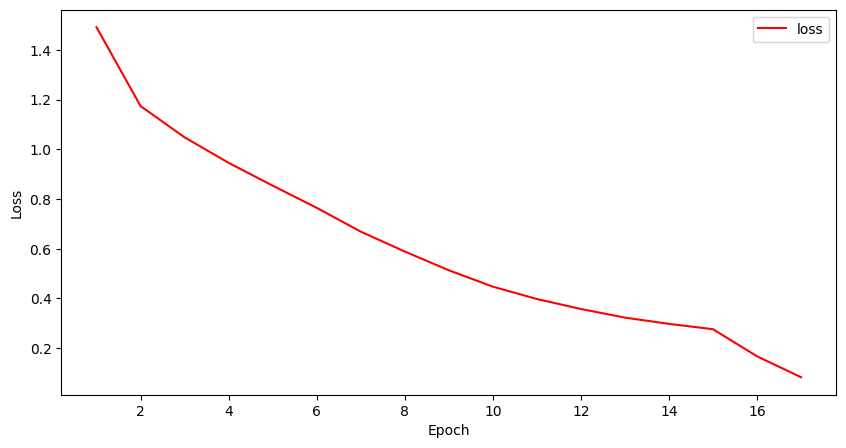

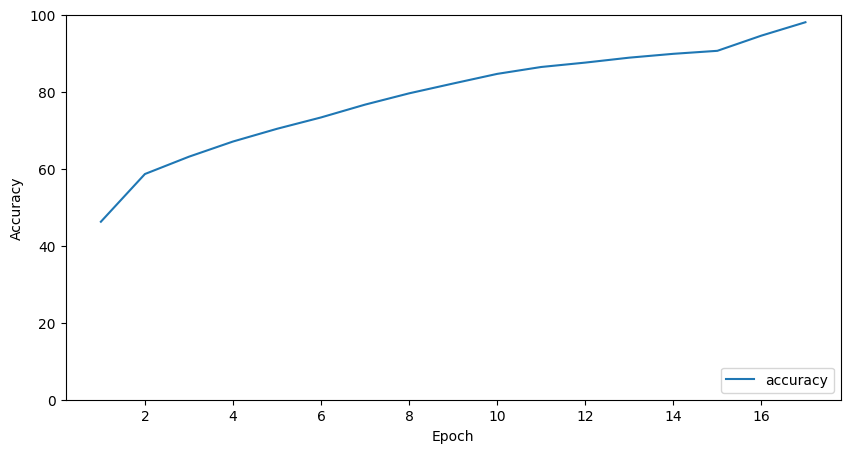

In [12]:
# Create a new figure for the loss vs. epoch plot for our CNN results

plt.figure(figsize=(10, 5))

# Plot the loss values
plt.plot(range(1, count_epochs + 1), loss_list, label='loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.figure(figsize=(10, 5))

plt.plot(range(1, count_epochs + 1), accuracy_list, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend(loc='lower right')
plt.show()

# Part 2- Implementing other models

## LeNet

Epoch 1: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 461.93batch/s]


Epoch 1/17, Loss: 1.4860, Accuracy: 47.77%


Epoch 2: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 476.17batch/s]


Epoch 2/17, Loss: 1.1740, Accuracy: 59.68%


Epoch 3: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 391.75batch/s]


Epoch 3/17, Loss: 1.0145, Accuracy: 65.17%


Epoch 4: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 494.69batch/s]


Epoch 4/17, Loss: 0.8991, Accuracy: 69.09%


Epoch 5: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 443.94batch/s]


Epoch 5/17, Loss: 0.7912, Accuracy: 73.18%


Epoch 6: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 518.33batch/s]


Epoch 6/17, Loss: 0.7009, Accuracy: 76.35%


Epoch 7: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 505.60batch/s]


Epoch 7/17, Loss: 0.6063, Accuracy: 79.80%


Epoch 8: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 472.58batch/s]


Epoch 8/17, Loss: 0.5228, Accuracy: 82.91%


Epoch 9: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 500.80batch/s]


Epoch 9/17, Loss: 0.4611, Accuracy: 84.81%


Epoch 10: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 426.97batch/s]


Epoch 10/17, Loss: 0.4077, Accuracy: 86.67%


Epoch 11: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 527.92batch/s]


Epoch 11/17, Loss: 0.3551, Accuracy: 88.36%


Epoch 12: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 527.69batch/s]


Epoch 12/17, Loss: 0.3229, Accuracy: 89.49%


Epoch 13: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 508.71batch/s]


Epoch 13/17, Loss: 0.3006, Accuracy: 90.04%


Epoch 14: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 541.89batch/s]


Epoch 14/17, Loss: 0.2718, Accuracy: 91.21%


Epoch 15: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 548.77batch/s]


Epoch 15/17, Loss: 0.2612, Accuracy: 91.37%


Epoch 16: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 506.78batch/s]


Epoch 16/17, Loss: 0.1773, Accuracy: 94.54%


Epoch 17: 100%|████████████████████████████████████████| 782/782 [00:01<00:00, 522.18batch/s]


Epoch 17/17, Loss: 0.0858, Accuracy: 98.71%
Finished Training
Accuracy on the test set: 70.94%


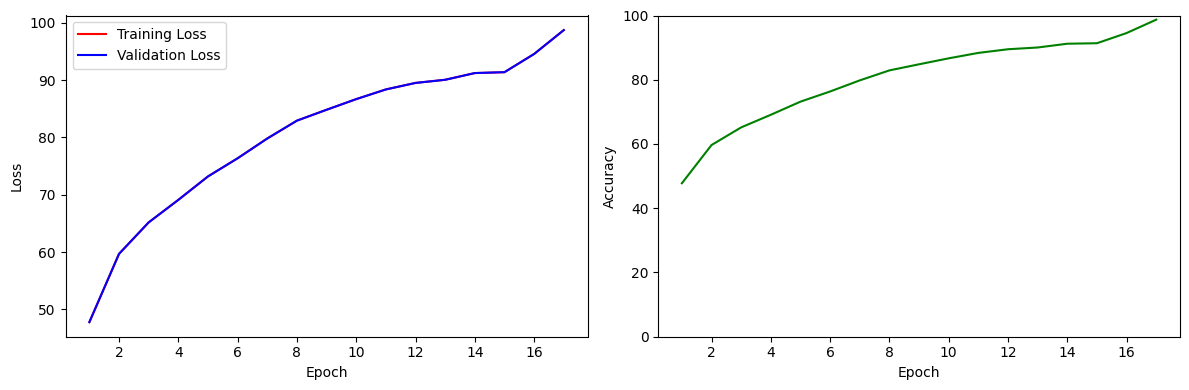

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.c1 = nn.Conv2d(3, 32, 5)
        self.c_b1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.c2 = nn.Conv2d(32, 64, 5)
        self.c_b2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.fc3_bn = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.pool(F.relu(self.c_b1(self.c1(x))))
        x = self.pool(F.relu(self.c_b2(self.c2(x))))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3_bn(self.fc3(x))
        return x


# Creating our LeNet model
model_lenet = LeNet()
model_lenet = model_lenet.to(set_gpu)

# optimizer_lenet = torch.optim.SGD(model_lenet.parameters(), lr=0.01, weight_decay=1e-5)

history_lenet = model_training(model_lenet, loader_train_data, count_epochs)

# Evaluating the LeNet model on the test data

# Evaluate and store accuracy for ModifiedLeNet
model_name = 'ModifiedLeNet'
accuracy = model_evalutaion(model_lenet, loader_test_data)  # Assuming evaluate_model returns accuracy
model_accuracies[model_name] = accuracy
model_lenet=model_lenet.cpu()

train_losses = history_lenet  
val_losses = history_lenet  
val_accuracies = history_lenet  
count_epochs = len(history_lenet)  

# Plot the training and validation losses for our LeNet model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, count_epochs + 1), train_losses, label='Training Loss', color='red')
plt.plot(range(1, count_epochs + 1), val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

## EfficientNet

Epoch 1: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.91batch/s]


Epoch 1/17, Loss: 1.8834, Accuracy: 29.20%


Epoch 2: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 45.69batch/s]


Epoch 2/17, Loss: 1.5858, Accuracy: 41.61%


Epoch 3: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.92batch/s]


Epoch 3/17, Loss: 1.3899, Accuracy: 49.32%


Epoch 4: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 43.78batch/s]


Epoch 4/17, Loss: 1.2483, Accuracy: 55.07%


Epoch 5: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.30batch/s]


Epoch 5/17, Loss: 1.1505, Accuracy: 58.90%


Epoch 6: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.64batch/s]


Epoch 6/17, Loss: 1.0764, Accuracy: 61.81%


Epoch 7: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 45.00batch/s]


Epoch 7/17, Loss: 1.0176, Accuracy: 64.02%


Epoch 8: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.71batch/s]


Epoch 8/17, Loss: 0.9634, Accuracy: 66.14%


Epoch 9: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 45.37batch/s]


Epoch 9/17, Loss: 0.9164, Accuracy: 67.92%


Epoch 10: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 45.33batch/s]


Epoch 10/17, Loss: 0.8787, Accuracy: 69.35%


Epoch 11: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 45.63batch/s]


Epoch 11/17, Loss: 0.8432, Accuracy: 70.62%


Epoch 12: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 45.49batch/s]


Epoch 12/17, Loss: 0.8096, Accuracy: 71.83%


Epoch 13: 100%|████████████████████████████████████████| 782/782 [00:18<00:00, 42.33batch/s]


Epoch 13/17, Loss: 0.7842, Accuracy: 72.97%


Epoch 14: 100%|████████████████████████████████████████| 782/782 [00:18<00:00, 42.28batch/s]


Epoch 14/17, Loss: 0.7576, Accuracy: 73.93%


Epoch 15: 100%|████████████████████████████████████████| 782/782 [00:18<00:00, 42.37batch/s]


Epoch 15/17, Loss: 0.7323, Accuracy: 74.49%


Epoch 16: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.97batch/s]


Epoch 16/17, Loss: 0.6035, Accuracy: 79.25%


Epoch 17: 100%|████████████████████████████████████████| 782/782 [00:17<00:00, 44.50batch/s]


Epoch 17/17, Loss: 0.5386, Accuracy: 81.50%
Finished Training
Accuracy on the test set: 71.55%


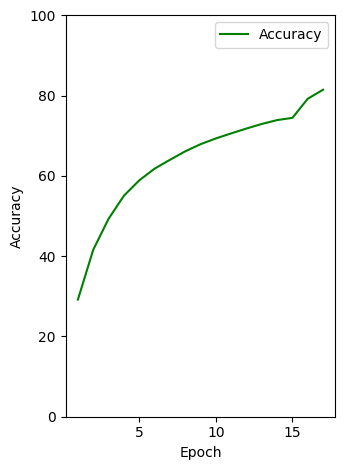

In [14]:

# Defining a custom EfficientNet model for our analysis
from efficientnet_pytorch import EfficientNet

class ModelEfficientNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelEfficientNet, self).__init__()
        self.efficientnet = EfficientNet.from_name('efficientnet-b0')  
        in_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

# Initializing the EfficientNet model
model_efficientnet = ModelEfficientNet(num_classes=10)  # Specify num_classes for CIFAR-10

# Moving the model to the processing_device
model_efficientnet = model_efficientnet.to(set_gpu)

train_accuracy_list = model_training(model_efficientnet, loader_train_data, count_epochs)

# # Evaluating the EfficientNet model and store accuracy for ModifiedEfficientNet

model_name = 'ModifiedEfficientNet'
accuracy = model_evalutaion(model_efficientnet, loader_test_data)  # Assuming evaluate_model returns accuracy
model_accuracies[model_name] = accuracy

model_efficientnet=model_efficientnet.cpu()
# Plot the accuracy for our EfficientNet model
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), train_accuracy_list, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()



## ResNet18

/home/kyrotron/miniconda3/envs/ptrch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kyrotron/miniconda3/envs/ptrch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|████████████████████████████████████████| 782/782 [00:09<00:00, 85.54batch/s]


Epoch 1/17, Loss: 1.1776, Accuracy: 59.66%


Epoch 2: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 86.95batch/s]


Epoch 2/17, Loss: 0.8700, Accuracy: 70.65%


Epoch 3: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.65batch/s]


Epoch 3/17, Loss: 0.7438, Accuracy: 75.12%


Epoch 4: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.67batch/s]


Epoch 4/17, Loss: 0.6450, Accuracy: 78.54%


Epoch 5: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.33batch/s]


Epoch 5/17, Loss: 0.5631, Accuracy: 81.04%


Epoch 6: 100%|████████████████████████████████████████| 782/782 [00:09<00:00, 85.70batch/s]


Epoch 6/17, Loss: 0.4939, Accuracy: 83.44%


Epoch 7: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.76batch/s]


Epoch 7/17, Loss: 0.4433, Accuracy: 85.06%


Epoch 8: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 88.36batch/s]


Epoch 8/17, Loss: 0.3941, Accuracy: 86.87%


Epoch 9: 100%|████████████████████████████████████████| 782/782 [00:09<00:00, 84.20batch/s]


Epoch 9/17, Loss: 0.3549, Accuracy: 88.04%


Epoch 10: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.91batch/s]


Epoch 10/17, Loss: 0.3313, Accuracy: 88.71%


Epoch 11: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.61batch/s]


Epoch 11/17, Loss: 0.3058, Accuracy: 89.60%


Epoch 12: 100%|████████████████████████████████████████| 782/782 [00:09<00:00, 85.44batch/s]


Epoch 12/17, Loss: 0.2808, Accuracy: 90.40%


Epoch 13: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.11batch/s]


Epoch 13/17, Loss: 0.2707, Accuracy: 90.79%


Epoch 14: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.35batch/s]


Epoch 14/17, Loss: 0.2586, Accuracy: 91.16%


Epoch 15: 100%|████████████████████████████████████████| 782/782 [00:09<00:00, 86.23batch/s]


Epoch 15/17, Loss: 0.2443, Accuracy: 91.48%


Epoch 16: 100%|████████████████████████████████████████| 782/782 [00:08<00:00, 87.18batch/s]


Epoch 16/17, Loss: 0.1304, Accuracy: 95.79%


Epoch 17: 100%|████████████████████████████████████████| 782/782 [00:09<00:00, 85.68batch/s]


Epoch 17/17, Loss: 0.0408, Accuracy: 99.16%
Finished Training
Accuracy on the test set: 77.77%


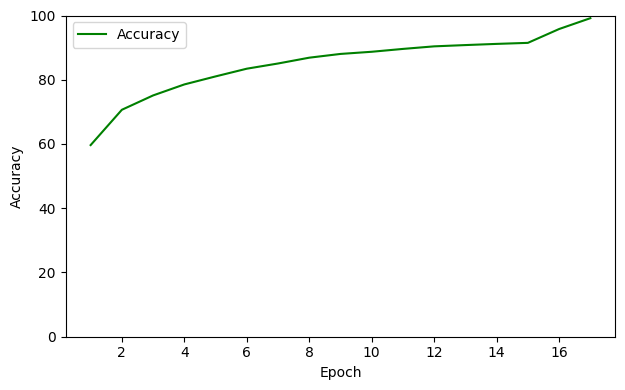

In [15]:
# Define our custom ResNet18 model

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet18(x)

model_resnet18 = ResNet18()
model_resnet18 = model_resnet18.to(set_gpu)

# Training and and evaluating the ResNet model
accuracy_list_resnet = model_training(model_resnet18, loader_train_data, count_epochs)

# Storing accuracy for ModifiedResNet18
model_name = 'ModifiedResNet18'
accuracy = model_evalutaion(model_resnet18, loader_test_data)  # Assuming evaluate_model returns accuracy
model_accuracies[model_name] = accuracy
model_resnet18=model_resnet18.cpu()
# Creating plots for accuracy and  for our resnet 18 model
plt.figure(figsize=(12, 4))

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), accuracy_list_resnet, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## ResNet50


/home/kyrotron/miniconda3/envs/ptrch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.32batch/s]


Epoch 1/17, Loss: 1.1515, Accuracy: 60.53%


Epoch 2: 100%|████████████████████████████████████████| 782/782 [00:25<00:00, 30.13batch/s]


Epoch 2/17, Loss: 0.8668, Accuracy: 70.97%


Epoch 3: 100%|████████████████████████████████████████| 782/782 [00:25<00:00, 30.35batch/s]


Epoch 3/17, Loss: 0.7790, Accuracy: 74.15%


Epoch 4: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.57batch/s]


Epoch 4/17, Loss: 0.7150, Accuracy: 76.40%


Epoch 5: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.92batch/s]


Epoch 5/17, Loss: 0.6596, Accuracy: 78.18%


Epoch 6: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.54batch/s]


Epoch 6/17, Loss: 0.6020, Accuracy: 80.05%


Epoch 7: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.71batch/s]


Epoch 7/17, Loss: 0.5572, Accuracy: 81.42%


Epoch 8: 100%|████████████████████████████████████████| 782/782 [00:25<00:00, 30.49batch/s]


Epoch 8/17, Loss: 0.5081, Accuracy: 83.00%


Epoch 9: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.87batch/s]


Epoch 9/17, Loss: 0.4755, Accuracy: 84.14%


Epoch 10: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.89batch/s]


Epoch 10/17, Loss: 0.4413, Accuracy: 85.17%


Epoch 11: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.65batch/s]


Epoch 11/17, Loss: 0.4071, Accuracy: 86.12%


Epoch 12: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.84batch/s]


Epoch 12/17, Loss: 0.3929, Accuracy: 86.65%


Epoch 13: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.46batch/s]


Epoch 13/17, Loss: 0.3667, Accuracy: 87.65%


Epoch 14: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.64batch/s]


Epoch 14/17, Loss: 0.3511, Accuracy: 87.97%


Epoch 15: 100%|████████████████████████████████████████| 782/782 [00:26<00:00, 29.59batch/s]


Epoch 15/17, Loss: 0.3360, Accuracy: 88.63%


Epoch 16: 100%|████████████████████████████████████████| 782/782 [00:25<00:00, 30.18batch/s]


Epoch 16/17, Loss: 0.1983, Accuracy: 93.47%


Epoch 17: 100%|████████████████████████████████████████| 782/782 [00:25<00:00, 30.91batch/s]


Epoch 17/17, Loss: 0.0915, Accuracy: 97.56%
Finished Training
Accuracy on the test set: 81.87%


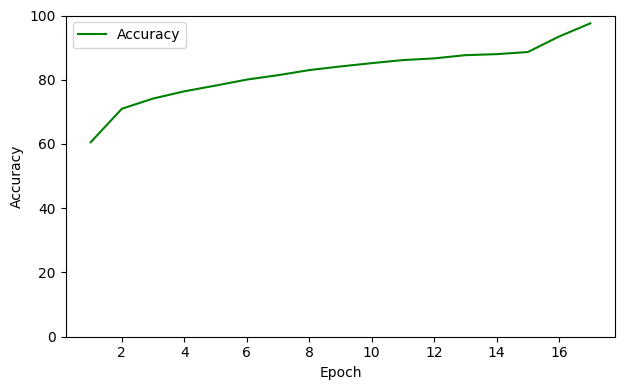

In [16]:
# Defining our custom model for ResNet50.

class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)

resnet50mod = ResNet50()

# Moving model to GPU
resnet50mod = resnet50mod.to(set_gpu)

# Training the model
accuracy_list_resnet50 = model_training(resnet50mod, loader_train_data, count_epochs)

# Evaluating and storing accuracy for ModifiedResNet50
model_name = 'ModifiedResNet50'
accuracy = model_evalutaion(resnet50mod, loader_test_data)  # Assuming evaluate_model returns accuracy
model_accuracies[model_name] = accuracy
resnet50mod=resnet50mod.cpu()
# Create plots for accuracy and loss
plt.figure(figsize=(12, 4))

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), accuracy_list_resnet50, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

# Part 3

## Comparison

CNN Accuracy: 73.55%
ModifiedLeNet Accuracy: 70.94%
ModifiedEfficientNet Accuracy: 71.55%
ModifiedResNet18 Accuracy: 77.77%
ModifiedResNet50 Accuracy: 81.87%


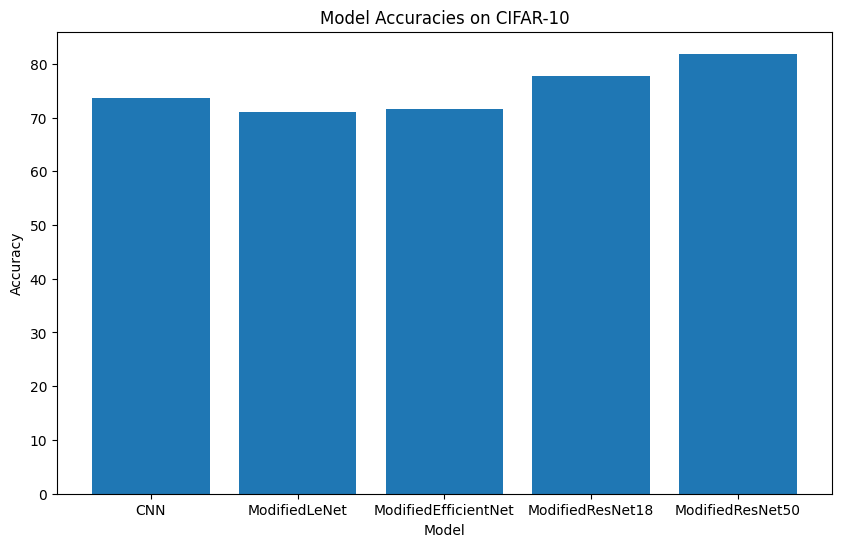

In [17]:
# Print the model accuracies
for model_CNN, accuracy in model_accuracies.items():
    print(f"{model_CNN} Accuracy: {accuracy:.2f}%")

# Creating a histogram of model accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies on CIFAR-10')
plt.show()